In [1]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy
import nltk

import geopandas as gpd

import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
#import proplot as plot
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
import seaborn as sns
#import geoplot as gplt
import warnings
warnings.filterwarnings('ignore')

import sddk
import tempun

In [2]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

In [3]:
# read local version:
LIREg = gpd.read_file("../data/large_data/LIREg_occupsorgs.geojson", driver="GeoJSON")
# or use the version from sciencedata
#LIREg = s.read_file("SDAM_data/social_diversity/LIRE_occupsorgs_2021-08-31.geojson", "gdf")
LIREg.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,curator,geometry
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,minor,0.097513,honorific inscription,1.0,[],0,[],0,[],POINT (20.76680 39.45120)
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,big,0.004249,mile-/leaguestone,1.0,[],0,[],0,[],POINT (22.41710 37.43190)
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,big,0.004249,public legal inscription,1.0,[],0,[],0,[],POINT (22.41710 37.43190)
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,minor,0.520308,votive inscription,1.0,[],0,[],0,[],POINT (24.83230 37.81880)
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{},{},...,minor,0.262624,owner/artist inscription,1.0,[],0,[],0,[],POINT (21.62710 37.64790)


In [4]:
def try_eval(cell_value):
    try: return eval(cell_value)
    except: return cell_value
for col in LIREg.columns:
    LIREg[col] = LIREg[col].apply(try_eval)

# Networks from occups - development

In [169]:
#def correct_occups(list_of_occups):
#    list_of_occups = ["ferrarius" if oc=="ferrarii" else oc for oc in list_of_occups]
#    return list_of_occups

In [218]:
LIREg["occups"] = LIREg["occups"].apply(correct_occups)

In [219]:
LIRE_occups = LIREg[LIREg["occups_N"] > 0]

In [411]:
occupslist = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIRE_occups["occups"].tolist()]
occupslist[:20]

['poeta',
 'faber',
 'curator',
 'curator',
 'navigans',
 'curator',
 'sector',
 'faber',
 'curator',
 'curator',
 'caligarius lapidarius',
 'vestiarius',
 'sagarius',
 'colorator',
 'anularius faber',
 'negotiator ferrarius',
 'dendrophorus faber',
 'figulus',
 'curator',
 'dolator']

In [412]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(occupslist)

In [413]:
vectorizer.vocabulary_["faber"]

108

In [414]:
vectorizer.get_feature_names()

['abietarius',
 'acceptor',
 'acuclarius',
 'aedifex',
 'aeneator',
 'aerarius',
 'agricola',
 'agrimensor',
 'albarius',
 'anabolicarius',
 'anaglyptarius',
 'annonarius',
 'anularius',
 'apparator',
 'aquarius',
 'arcarius',
 'archimagirus',
 'architectus',
 'arenarius',
 'argentarius',
 'armamentarius',
 'aromatarius',
 'artefex',
 'artifex',
 'athleta',
 'aurarius',
 'aurifex',
 'aurificus',
 'aurufex',
 'automatarius',
 'axearius',
 'ballistarius',
 'barbaricarius',
 'boarius',
 'brattiarius',
 'caelator',
 'caementarius',
 'calcarensis',
 'calcariensis',
 'calcarius',
 'calciator',
 'calegarius',
 'caligarius',
 'camararius',
 'canalicularius',
 'candidarius',
 'candidator',
 'caplator',
 'capsarius',
 'capulator',
 'carbonarus',
 'carminator',
 'carpentarius',
 'caudicarius',
 'caupo',
 'cellararius',
 'cellarius',
 'cellio',
 'centonarius',
 'cerarius',
 'cerdo',
 'cervesarius',
 'chartarius',
 'circitor',
 'cisianus',
 'cisiarius',
 'clavarius',
 'clavicularius',
 'clibanarius

In [415]:
# word-document matrix
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
X_df.head()

,abietarius,acceptor,acuclarius,aedifex,aeneator,aerarius,agricola,agrimensor,albarius,anabolicarius,...,vestiarius,vestificus,vestiplicus,vestitor,veterarius,vexillarius,vinariarius,vinarius,vitrarius,vitriarius
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [416]:
# word-word co-occurrence matrix
Xc = X.T * X
Xc_df = pd.DataFrame(Xc.todense(), index=vectorizer.get_feature_names(), columns=vectorizer.get_feature_names())
Xc_df.head(20)

,abietarius,acceptor,acuclarius,aedifex,aeneator,aerarius,agricola,agrimensor,albarius,anabolicarius,...,vestiarius,vestificus,vestiplicus,vestitor,veterarius,vexillarius,vinariarius,vinarius,vitrarius,vitriarius
abietarius,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acceptor,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acuclarius,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aedifex,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aeneator,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aerarius,0,0,0,0,0,273,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
agricola,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agrimensor,0,0,0,0,0,0,0,68,0,0,...,0,0,0,0,0,0,0,0,0,0
albarius,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
anabolicarius,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [417]:
Xc.toarray()

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 0,  5,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 63,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  1]])

In [418]:
wordcounts = X.toarray().sum(axis=0)
wordcounts[:10]

array([  1,   5,   1,   7,   4, 237,   3,  12,   1,   1])

In [419]:
nodes_dict = dict([(pair[1], {"wordcount" : wordcounts[pair[1]]}) for pair in vectorizer.vocabulary_.items()])
labels_mapping = dict([(pair[1], pair[0]) for pair in vectorizer.vocabulary_.items()])
nodes_dict

{243: {'wordcount': 9},
 108: {'wordcount': 690},
 91: {'wordcount': 1069},
 203: {'wordcount': 4},
 287: {'wordcount': 2},
 42: {'wordcount': 7},
 160: {'wordcount': 17},
 337: {'wordcount': 50},
 266: {'wordcount': 26},
 75: {'wordcount': 6},
 12: {'wordcount': 10},
 207: {'wordcount': 148},
 117: {'wordcount': 7},
 95: {'wordcount': 68},
 121: {'wordcount': 3},
 99: {'wordcount': 1},
 282: {'wordcount': 224},
 186: {'wordcount': 252},
 26: {'wordcount': 16},
 229: {'wordcount': 1},
 51: {'wordcount': 2},
 208: {'wordcount': 23},
 342: {'wordcount': 77},
 5: {'wordcount': 237},
 36: {'wordcount': 1},
 184: {'wordcount': 24},
 219: {'wordcount': 25},
 218: {'wordcount': 8},
 300: {'wordcount': 26},
 126: {'wordcount': 7},
 295: {'wordcount': 1},
 276: {'wordcount': 45},
 6: {'wordcount': 3},
 247: {'wordcount': 14},
 189: {'wordcount': 2},
 135: {'wordcount': 34},
 273: {'wordcount': 3},
 320: {'wordcount': 20},
 77: {'wordcount': 28},
 267: {'wordcount': 128},
 249: {'wordcount': 29}

In [420]:
labels_mapping

{243: 'poeta',
 108: 'faber',
 91: 'curator',
 203: 'navigans',
 287: 'sector',
 42: 'caligarius',
 160: 'lapidarius',
 337: 'vestiarius',
 266: 'sagarius',
 75: 'colorator',
 12: 'anularius',
 207: 'negotiator',
 117: 'ferrarius',
 95: 'dendrophorus',
 121: 'figulus',
 99: 'dolator',
 282: 'scriba',
 186: 'medicus',
 26: 'aurifex',
 229: 'pectinarius',
 51: 'carminator',
 208: 'nummularius',
 342: 'vexillarius',
 5: 'aerarius',
 36: 'caementarius',
 184: 'marmorarius',
 219: 'ornatrix',
 218: 'ornator',
 300: 'structor',
 126: 'forensis',
 295: 'soliarius',
 276: 'scaenicus',
 6: 'agricola',
 247: 'pomarius',
 189: 'mesor',
 135: 'gladiator',
 273: 'sartor',
 320: 'tonsor',
 77: 'conditor',
 267: 'sagittarius',
 249: 'possessor',
 58: 'centonarius',
 308: 'sutor',
 319: 'tignuarius',
 310: 'tabernarius',
 331: 'utriclarius',
 170: 'lintiarius',
 1: 'acceptor',
 210: 'offector',
 304: 'subaedianus',
 336: 'venator',
 305: 'subidianus',
 34: 'brattiarius',
 253: 'purpurarius',
 145: 'in

In [421]:
G = nx.from_numpy_matrix(Xc.toarray())
G.remove_edges_from(nx.selfloop_edges(G))
nx.set_node_attributes(G, nodes_dict)

G = nx.relabel_nodes(G, labels_mapping)
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [422]:
G.edges(data=True)

EdgeDataView([('acceptor', 'mensor', {'weight': 2}), ('acceptor', 'nauticarius', {'weight': 1}), ('aedifex', 'pomarius', {'weight': 1}), ('aedifex', 'rosarius', {'weight': 1}), ('aerarius', 'argentarius', {'weight': 3}), ('aerarius', 'candidator', {'weight': 1}), ('aerarius', 'centonarius', {'weight': 1}), ('aerarius', 'cerarius', {'weight': 2}), ('aerarius', 'cisianus', {'weight': 2}), ('aerarius', 'curator', {'weight': 65}), ('aerarius', 'curator_navium', {'weight': 3}), ('aerarius', 'dendrophorus', {'weight': 3}), ('aerarius', 'dominus_navium', {'weight': 1}), ('aerarius', 'faber', {'weight': 12}), ('aerarius', 'ferrarius', {'weight': 1}), ('aerarius', 'gladiator', {'weight': 4}), ('aerarius', 'lenuncularius', {'weight': 2}), ('aerarius', 'margaritarius', {'weight': 1}), ('aerarius', 'medicus', {'weight': 1}), ('aerarius', 'mensor', {'weight': 2}), ('aerarius', 'mercator', {'weight': 1}), ('aerarius', 'navalis', {'weight': 3}), ('aerarius', 'navicularius', {'weight': 2}), ('aerarius

In [423]:
G.nodes(data=True)

NodeDataView({'acceptor': {'wordcount': 5}, 'aedifex': {'wordcount': 7}, 'aerarius': {'wordcount': 237}, 'agricola': {'wordcount': 3}, 'anaglyptarius': {'wordcount': 1}, 'anularius': {'wordcount': 10}, 'apparator': {'wordcount': 4}, 'arcarius': {'wordcount': 37}, 'archimagirus': {'wordcount': 3}, 'architectus': {'wordcount': 41}, 'arenarius': {'wordcount': 2}, 'argentarius': {'wordcount': 80}, 'armamentarius': {'wordcount': 16}, 'artifex': {'wordcount': 6}, 'athleta': {'wordcount': 3}, 'aurifex': {'wordcount': 16}, 'automatarius': {'wordcount': 1}, 'boarius': {'wordcount': 2}, 'brattiarius': {'wordcount': 4}, 'caelator': {'wordcount': 3}, 'calcarius': {'wordcount': 4}, 'caligarius': {'wordcount': 7}, 'candidarius': {'wordcount': 1}, 'candidator': {'wordcount': 4}, 'caplator': {'wordcount': 3}, 'capsarius': {'wordcount': 10}, 'carminator': {'wordcount': 2}, 'carpentarius': {'wordcount': 2}, 'caupo': {'wordcount': 4}, 'cellarius': {'wordcount': 12}, 'centonarius': {'wordcount': 124}, 'ce

In [424]:
weights_log2 = [np.log2(w*10) for w in nx.get_edge_attributes(G,'weight').values()]
weights_log2[:10]

[4.321928094887363,
 3.321928094887362,
 3.321928094887362,
 3.321928094887362,
 4.906890595608519,
 3.321928094887362,
 3.321928094887362,
 4.321928094887363,
 4.321928094887363,
 9.344295907915816]

In [425]:
wordcounts_tups = sorted([(node[0], node[1]["wordcount"]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
words_by_count = [tup[0] for tup in wordcounts_tups]
words_by_count[:10]

['curator',
 'faber',
 'medicus',
 'aerarius',
 'scriba',
 'negotiator',
 'sagittarius',
 'centonarius',
 'mensor',
 'argentarius']

In [426]:
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occupations_df.head(5)

,Term,gen_sg,Vocab_nom_sg,Source,HISCO_majorgroup,HISCO_minorgroup,Harris_Category,Subcategory,Translation_eng
0,abetarius,i,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
1,abietarius,i,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
2,acceptor,oris,acceptor,Waltzing - Rome,3.0,31.0,Finance,NaN,"collector, gold quality checker"
3,accomodator,oris,NaN,Petrikovits 1981a,9.0,99.0,Unclear meaning,NaN,"uncertain, craftsman"
4,aceptor,oris,NaN,Petrikovits 1981a,3.0,31.0,Finance,NaN,"collector, gold quality checker"


In [427]:
occupations_df["Term"] = occupations_df["Term"].apply(lambda x: x.replace(" ", "_"))

In [428]:
occupations_df["HISCO_majorgroup"].unique()

array([ 8.,  3.,  9.,  6.,  0.,  1.,  7.,  4.,  5., nan,  2.])

In [429]:
hisco_cats_dict = {
    0.0 : "Professional, technical and related workers",
    1.0 : "Professional, technical and related workers",
    2.0 : "Administrative and managerial workers",
    3.0 : "Clerical and related workers",
    4.0 : "Sales workers",
    5.0 : "Service workers",
    6.0 : "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    7.0 : "Production and related workers, transport equipment operators and labourers",
    8.0 : "Production and related workers, transport equipment operators and labourers",
    9.0 : "Production and related workers, transport equipment operators and labourers",
}

In [430]:
def get_cat_name(x):
    try: return hisco_cats_dict[x]
    except: return "unclassified"
occupations_df["HISCO_majorgroup_names"] = occupations_df["HISCO_majorgroup"].apply(get_cat_name)

In [391]:
hisco_cats = occupations_df["HISCO_majorgroup_names"].unique().tolist()

In [432]:
hisco_colors_dict = {'Professional, technical and related workers': 'red',
 'Administrative and managerial workers': 'green',
 'Clerical and related workers': 'blue',
 'Sales workers': 'orange',
 'Service workers': 'purple',
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters': 'pink',
 'Production and related workers, transport equipment operators and labourers': 'darkturquoise',
 'unclassified': 'grey',}

In [433]:
#harris_cats = occupations_df["Harris_Category"].dropna().unique().tolist()
#harris_colors_dict = dict(zip(harris_cats, colors_list))
#harris_colors_dict

In [434]:
def assign_color(cat_code):
    try: return hisco_colors_dict[cat_code]
    except: return "grey"
occupations_df["color"] = occupations_df["HISCO_majorgroup_names"].apply(assign_color)

In [435]:
color_dict = occupations_df[["Term", "color"]].set_index("Term").to_dict()["color"]
color_dict

{'abetarius': 'darkturquoise',
 'abietarius': 'darkturquoise',
 'acceptor': 'blue',
 'accomodator': 'darkturquoise',
 'aceptor': 'blue',
 'aciscularius': 'darkturquoise',
 'acuarius': 'darkturquoise',
 'acuclarius': 'darkturquoise',
 'acucularius': 'darkturquoise',
 'acutarius': 'darkturquoise',
 'acutiator': 'pink',
 'adulterator': 'blue',
 'aedifex': 'red',
 'aedificator': 'red',
 'aeneator': 'red',
 'aequator_monetae': 'blue',
 'aerarius': 'darkturquoise',
 'agricola': 'pink',
 'agrimensor': 'red',
 'agrimesor': 'red',
 'albarius': 'darkturquoise',
 'alicarius': 'pink',
 'aluminarius': 'darkturquoise',
 'ampullarius': 'darkturquoise',
 'anabolicarius': 'darkturquoise',
 'anaglitarius': 'red',
 'anaglypharius': 'red',
 'anaglyptarius': 'red',
 'anellarius': 'darkturquoise',
 'annellarius': 'darkturquoise',
 'annonarius': 'blue',
 'anularius': 'darkturquoise',
 'apothecarius': 'orange',
 'apparator': 'darkturquoise',
 'applumbator': 'darkturquoise',
 'adplumbator': 'darkturquoise',
 '

In [436]:
len(color_dict)

814

In [483]:
def plot_network(G, N_nodes=50, node_size_attr="wordcount", edge_width_attr="weight", margins = 0.2, legend_dict=None,ax=None):
    nodes_sorted_tups =  node_sizes = sorted([(node[0], node[1][node_size_attr]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
    nodes_lables_sorted = [tup[0] for tup in nodes_sorted_tups]
    H = G.subgraph(nodes_lables_sorted[:N_nodes])
    node_colors = [color_dict[node] for node in H.nodes()]
    node_sizes = [w for w in nx.get_node_attributes(H, node_size_attr).values()]
    edge_sizes = [np.log2(w*5) for w in nx.get_edge_attributes(H, edge_width_attr).values()]
    pos = nx.kamada_kawai_layout(H) # generate the node positions
    if ax == None:
        fig, ax = plt.subplots()
    x_min, x_max, y_min, y_max = np.min([p[0] for p in pos.values()]), np.max([p[0] for p in pos.values()]), np.min([p[1] for p in pos.values()]), np.max([p[1] for p in pos.values()]) 
    ax.set_xlim(x_min - margins, x_max + margins)
    #ax.set_ylim(y_min - margins, y_max + margins)
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(H,
                          pos=pos,
                          alpha=0.5,
                          width= edge_sizes,
                          style="solid",
                          edge_color="gray",
                          ax=ax)
    layer_nodes = nx.draw_networkx_nodes(H,
                           pos=pos,
                           node_size=node_sizes, 
                           node_color=node_colors,
                           ax=ax)
    layer_labels = nx.draw_networkx_labels(H,
                           pos=pos, 
                           font_size=8,
                           ax=ax)
    if legend_dict != None:
        markers = [plt.Line2D([0,0],[0,0], marker="o", color=color, lw=0) for color in legend_dict.values()]
        ax.legend(markers, legend_dict.keys(), bbox_to_anchor=(0, 0), loc='upper left', frameon=False) 
    layers = [layer_edges, layer_nodes, layer_labels]
    return


def plot_network_simple(G, N_nodes=50, node_size_attr="wordcount", edge_width_attr="weight"):
    """a more simple variant of the same"""
    nodes_sorted_tups =  node_sizes = sorted([(node[0], node[1][node_size_attr]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
    nodes_lables_sorted = [tup[0] for tup in nodes_sorted_tups]
    ###
    H = G.subgraph(nodes_lables_sorted[:N_nodes])
    node_colors = [color_dict[node] for node in H.nodes()]
    edge_sizes = [np.log2(w*5) for w in nx.get_edge_attributes(H, edge_width_attr).values()]
    node_sizes = [w for w in nx.get_node_attributes(H, node_size_attr).values()]
    layer = nx.draw_kamada_kawai(H, 
                     with_labels=True,
                     node_size=node_sizes, 
                     node_color=node_colors,
                     font_size=8,
                     edge_color="gray", 
                     style="solid", 
                     width= edge_sizes,
                     #alpha=0.8
                                )
    return layer

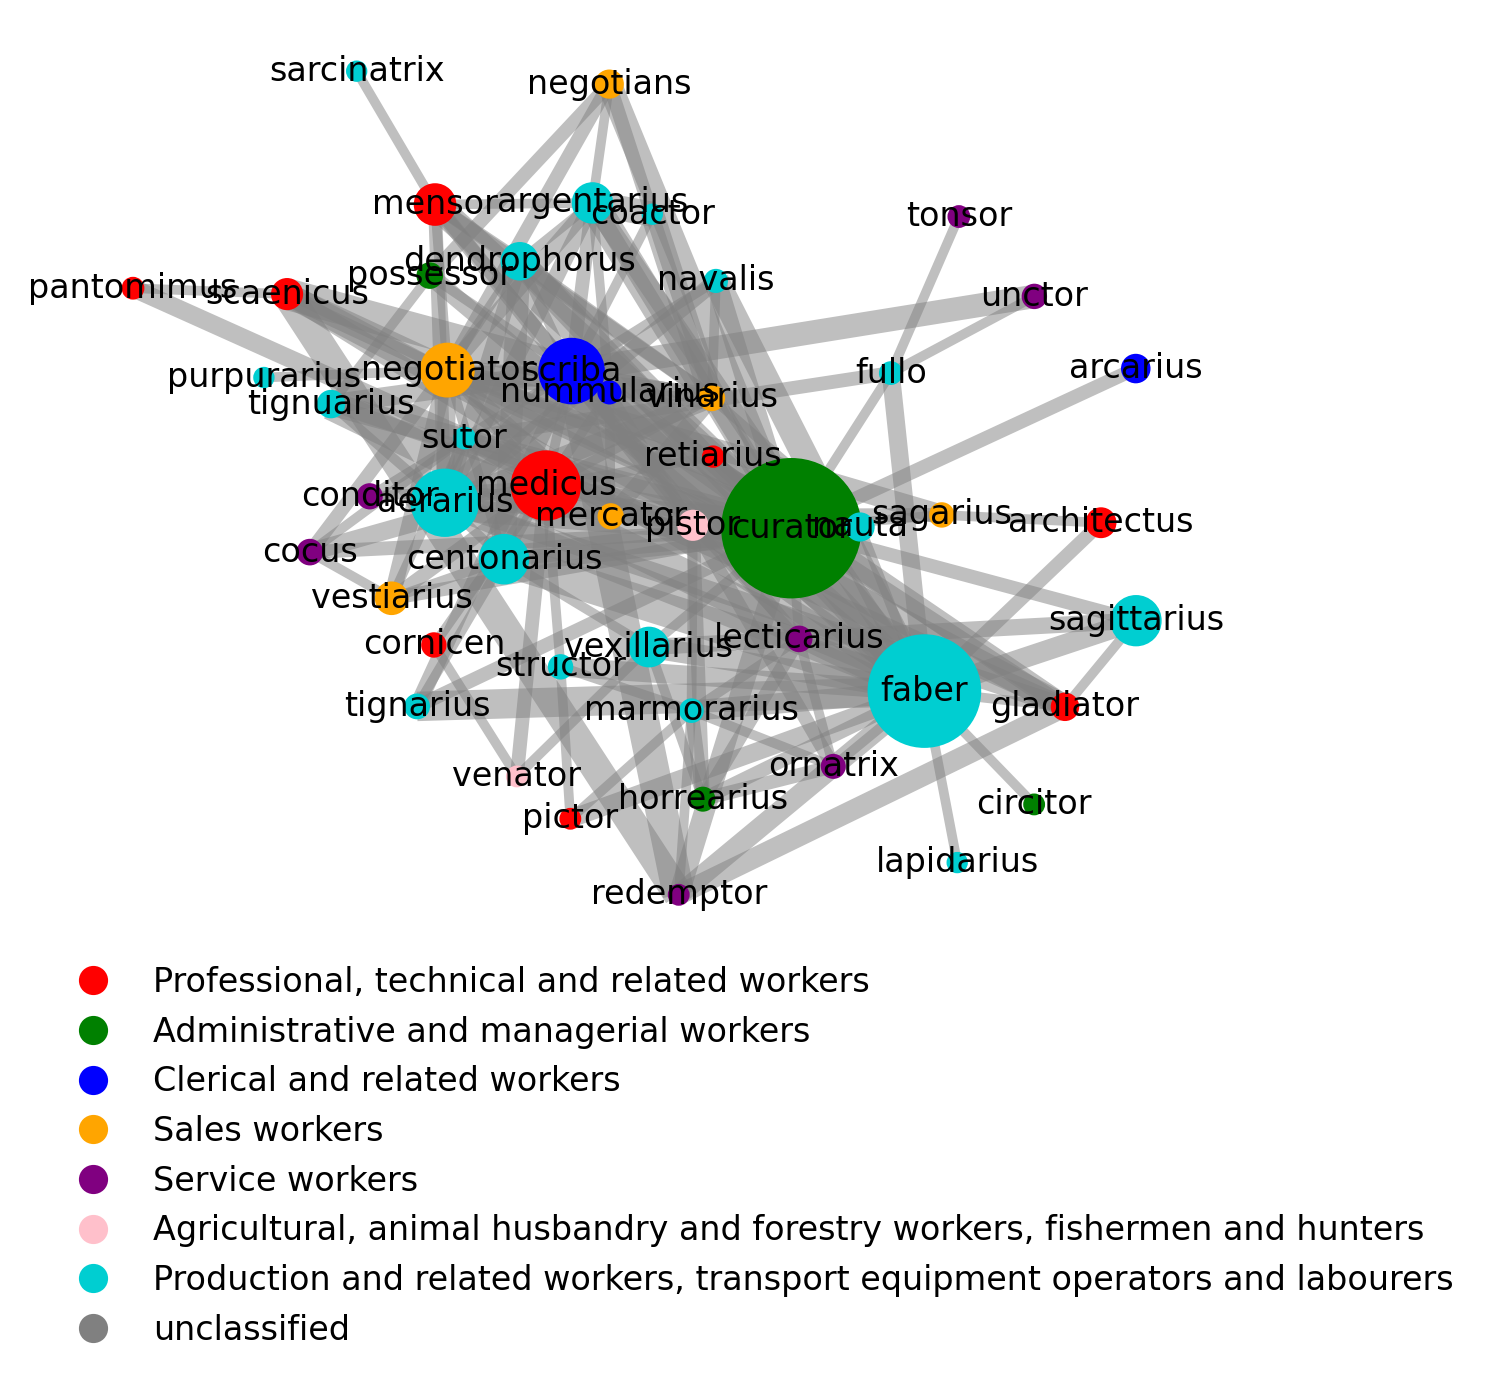

In [484]:
fig, ax = plt.subplots(figsize=(5.2, 4))
plot_network(G, N_nodes=50, legend_dict=hisco_colors_dict, ax=ax)

In [485]:
def network_from_stringlist(stringlist):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(stringlist)
    Xc = X.T * X
    wordcounts = X.toarray().sum(axis=0)
    nodes_dict = dict([(pair[1], {"wordcount" : wordcounts[pair[1]]}) for pair in vectorizer.vocabulary_.items()])
    labels_mapping = dict([(pair[1], pair[0]) for pair in vectorizer.vocabulary_.items()])
    G = nx.from_numpy_matrix(Xc.toarray())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.set_node_attributes(G, nodes_dict)
    G = nx.relabel_nodes(G, labels_mapping)
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    return G

In [486]:
G = network_from_stringlist(occupslist)

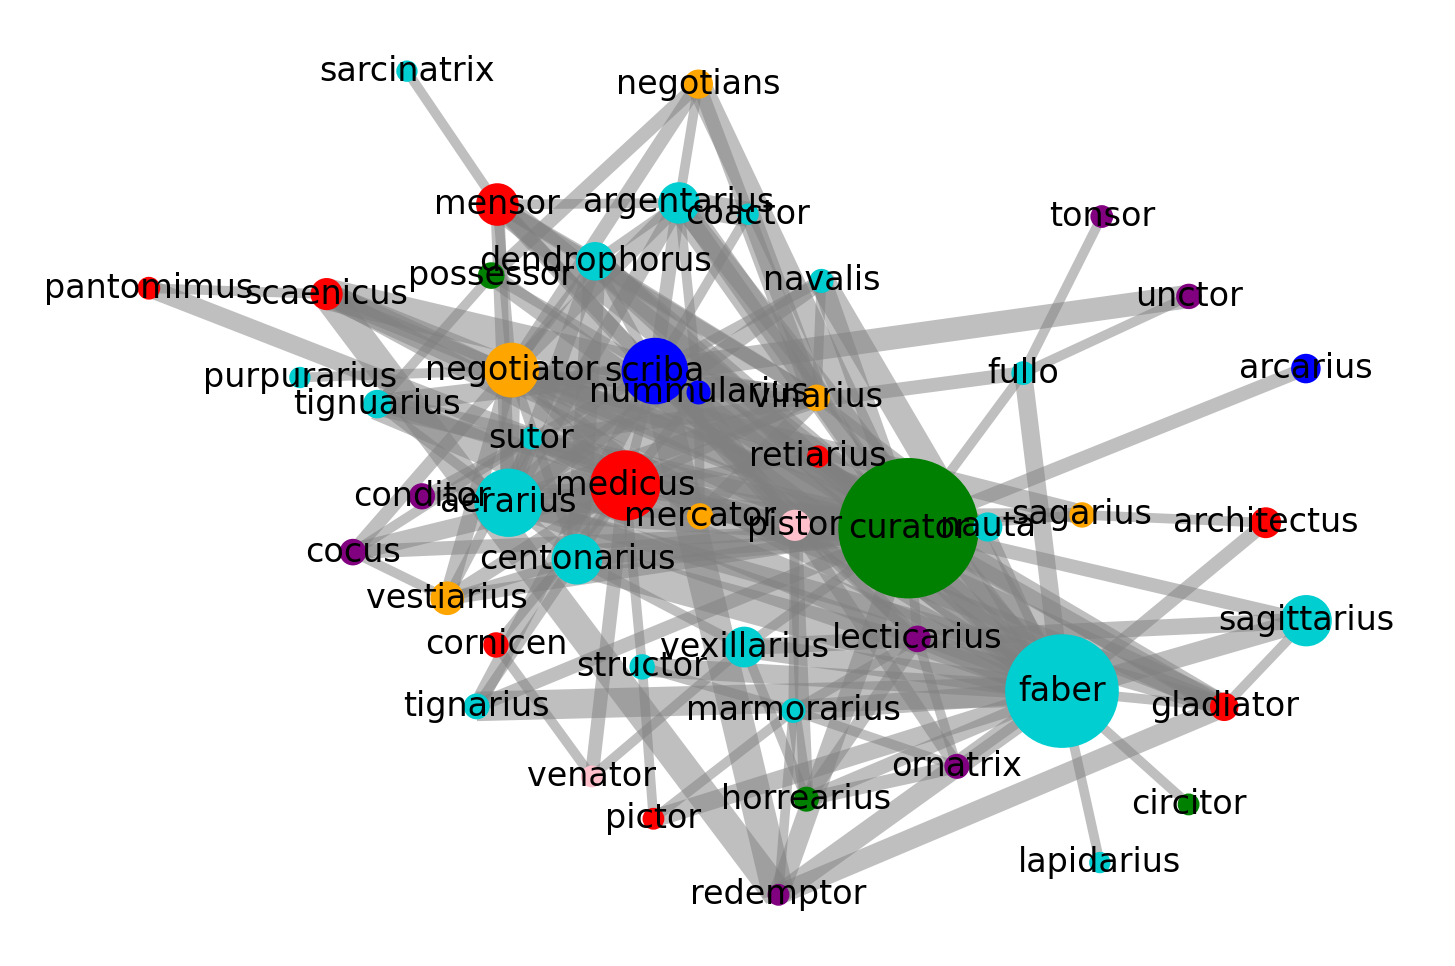

In [487]:
plot_network(G, N_nodes=50)

In [488]:
mask_big = LIRE_occups["nearest_city_type"]=="big"
mask_middle = LIRE_occups["nearest_city_type"]=="middle"
mask_minor = LIRE_occups["nearest_city_type"]=="minor"

occupslist_big = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIRE_occups[mask_big]["occups"].tolist()]
occupslist_middle = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIRE_occups[mask_middle]["occups"].tolist()]
occupslist_minor = [" ".join([el.replace(" ", "_") for el in olist]) for olist in LIRE_occups[mask_minor]["occups"].tolist()]

In [489]:
G_big = network_from_stringlist(occupslist_big)
G_middle = network_from_stringlist(occupslist_middle)
G_minor = network_from_stringlist(occupslist_minor)

In [490]:
len(G_big.nodes)

132

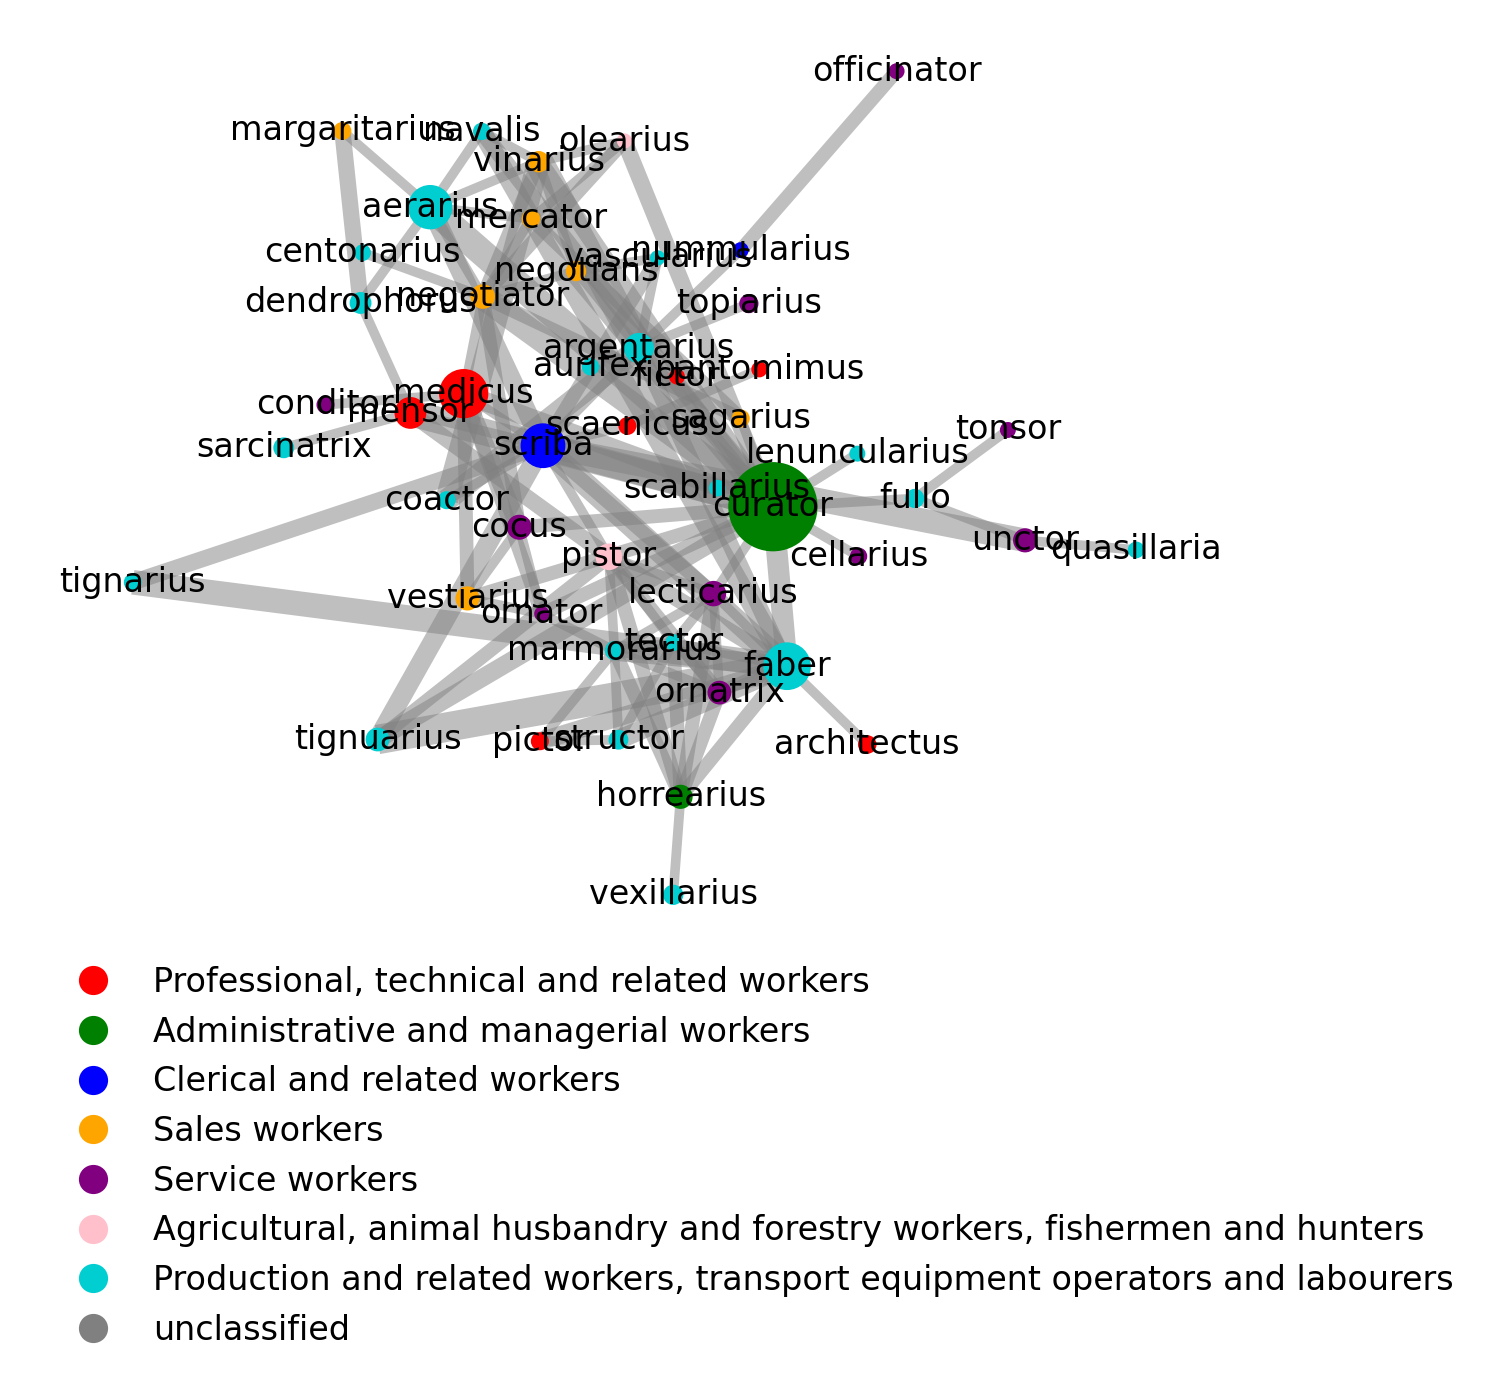

In [491]:
fig, ax = plt.subplots(figsize=(5.2, 4))
plot_network(G_big, legend_dict=hisco_colors_dict, ax=ax)

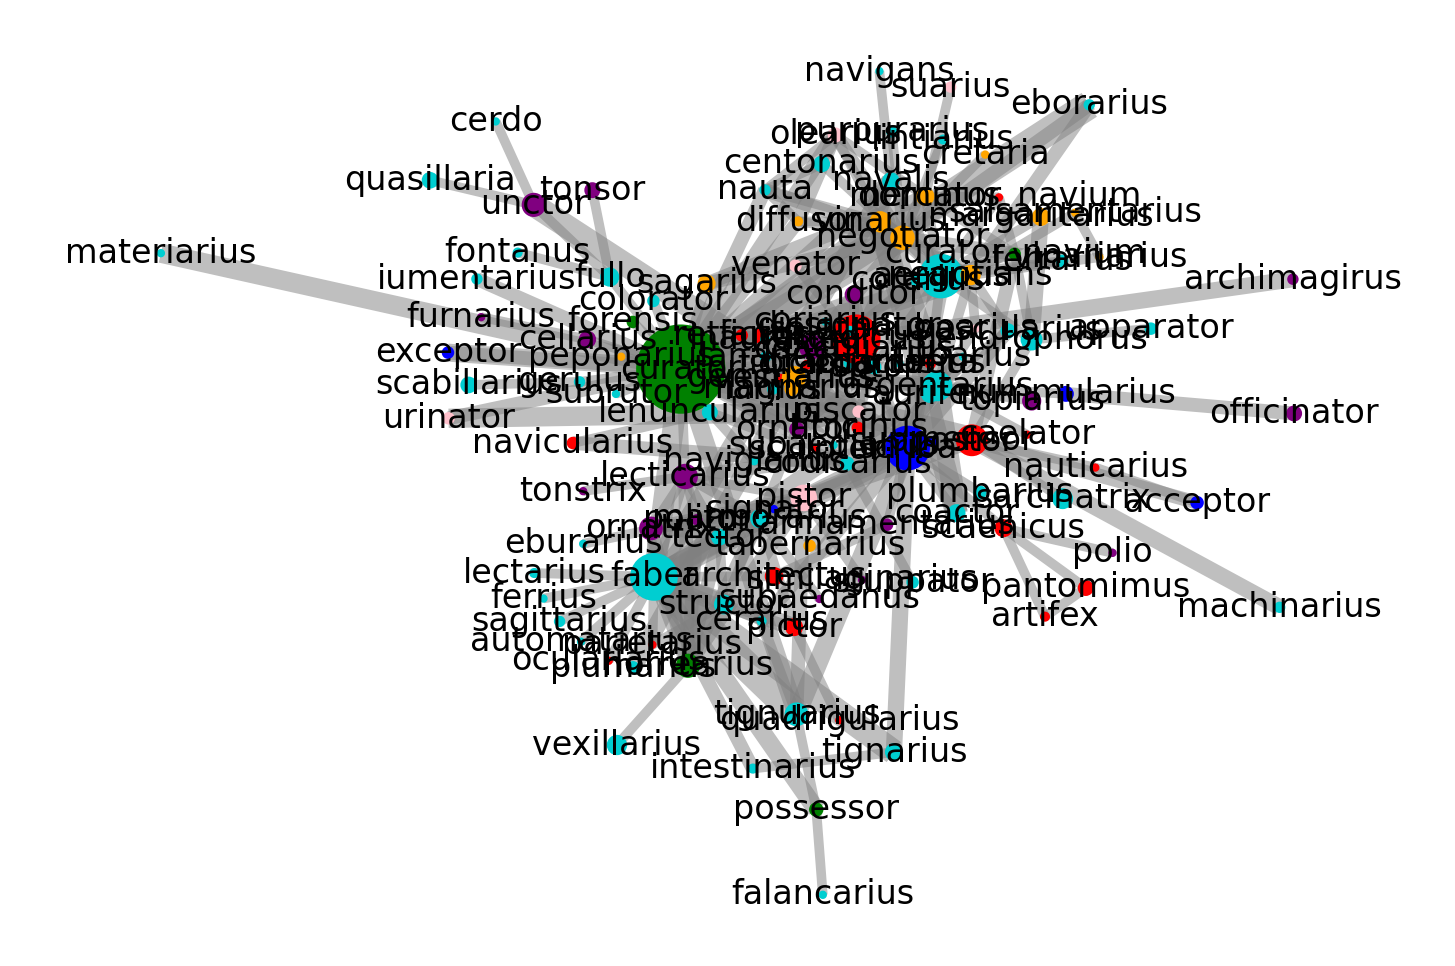

In [480]:
plot_network(G_big, N_nodes=len(G_big.nodes))

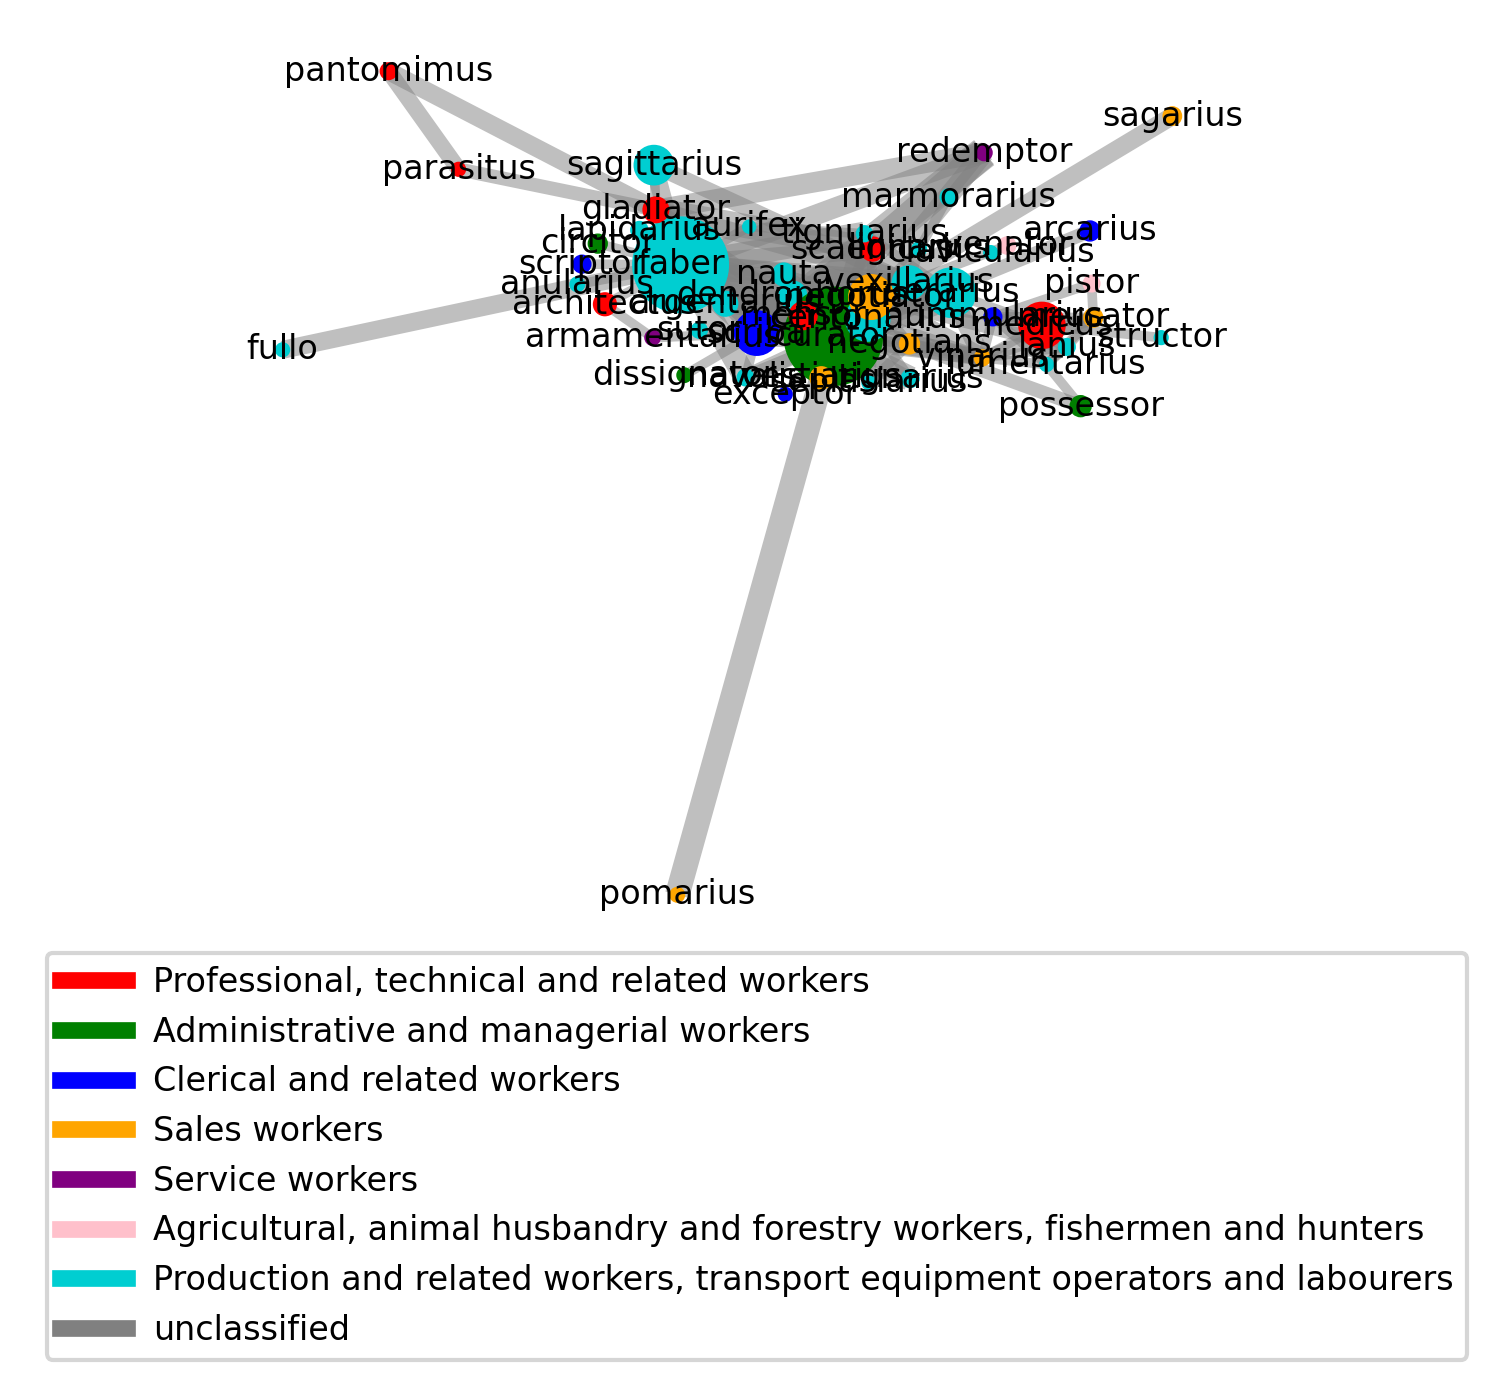

In [459]:
plot_network(G_middle, N_nodes=50, legend_dict=hisco_colors_dict)

No handles with labels found to put in legend.


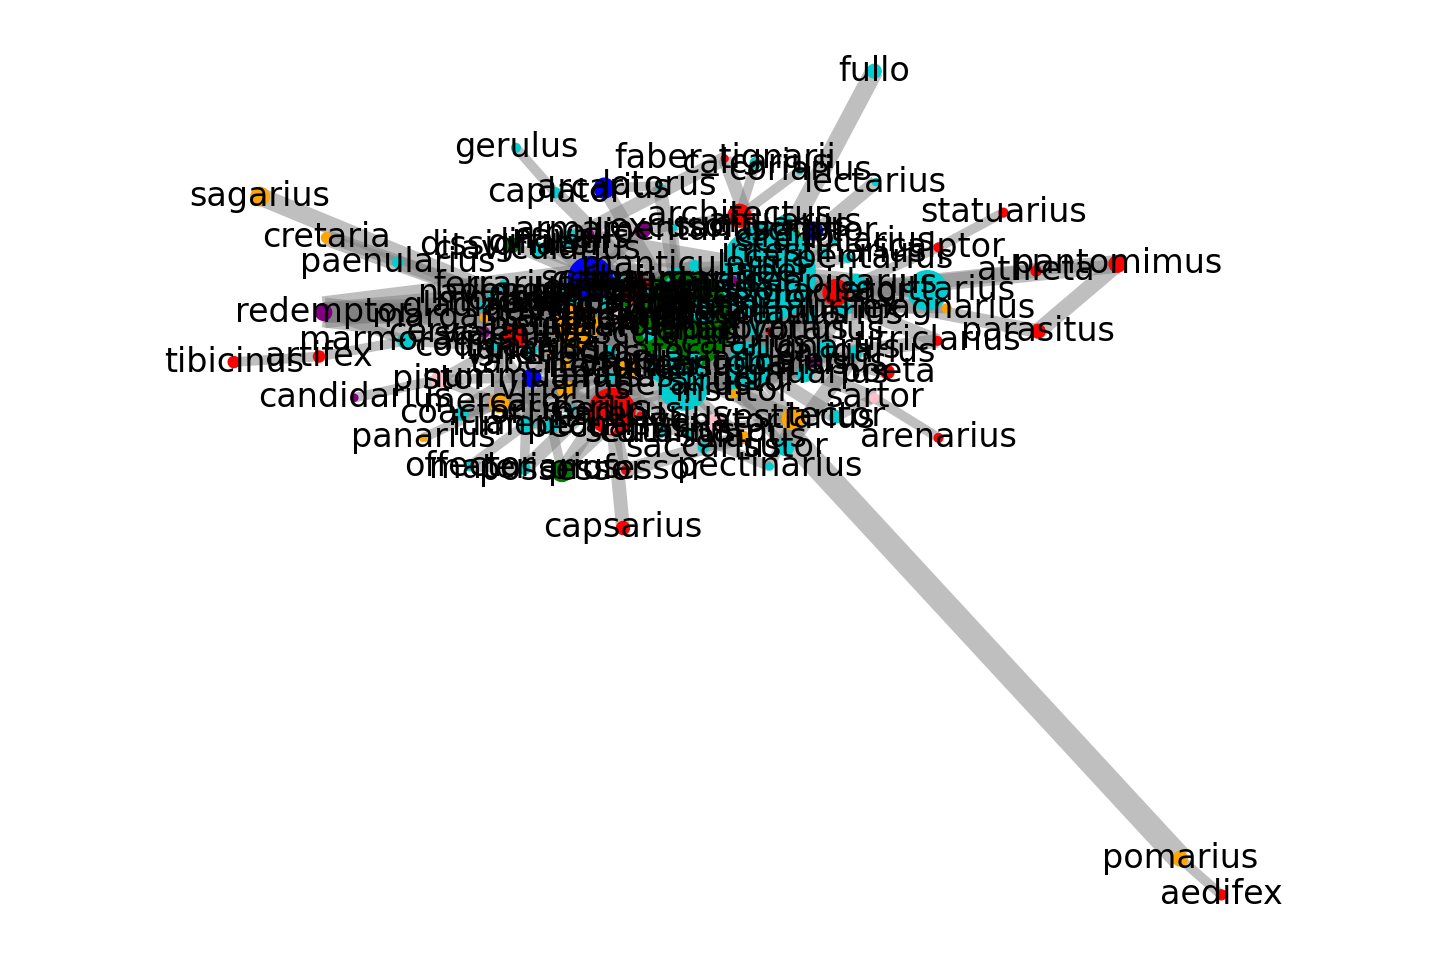

In [470]:
plot_network(G_middle, N_nodes=len(G_middle.nodes), legend_dict=hisco_colors_dict)

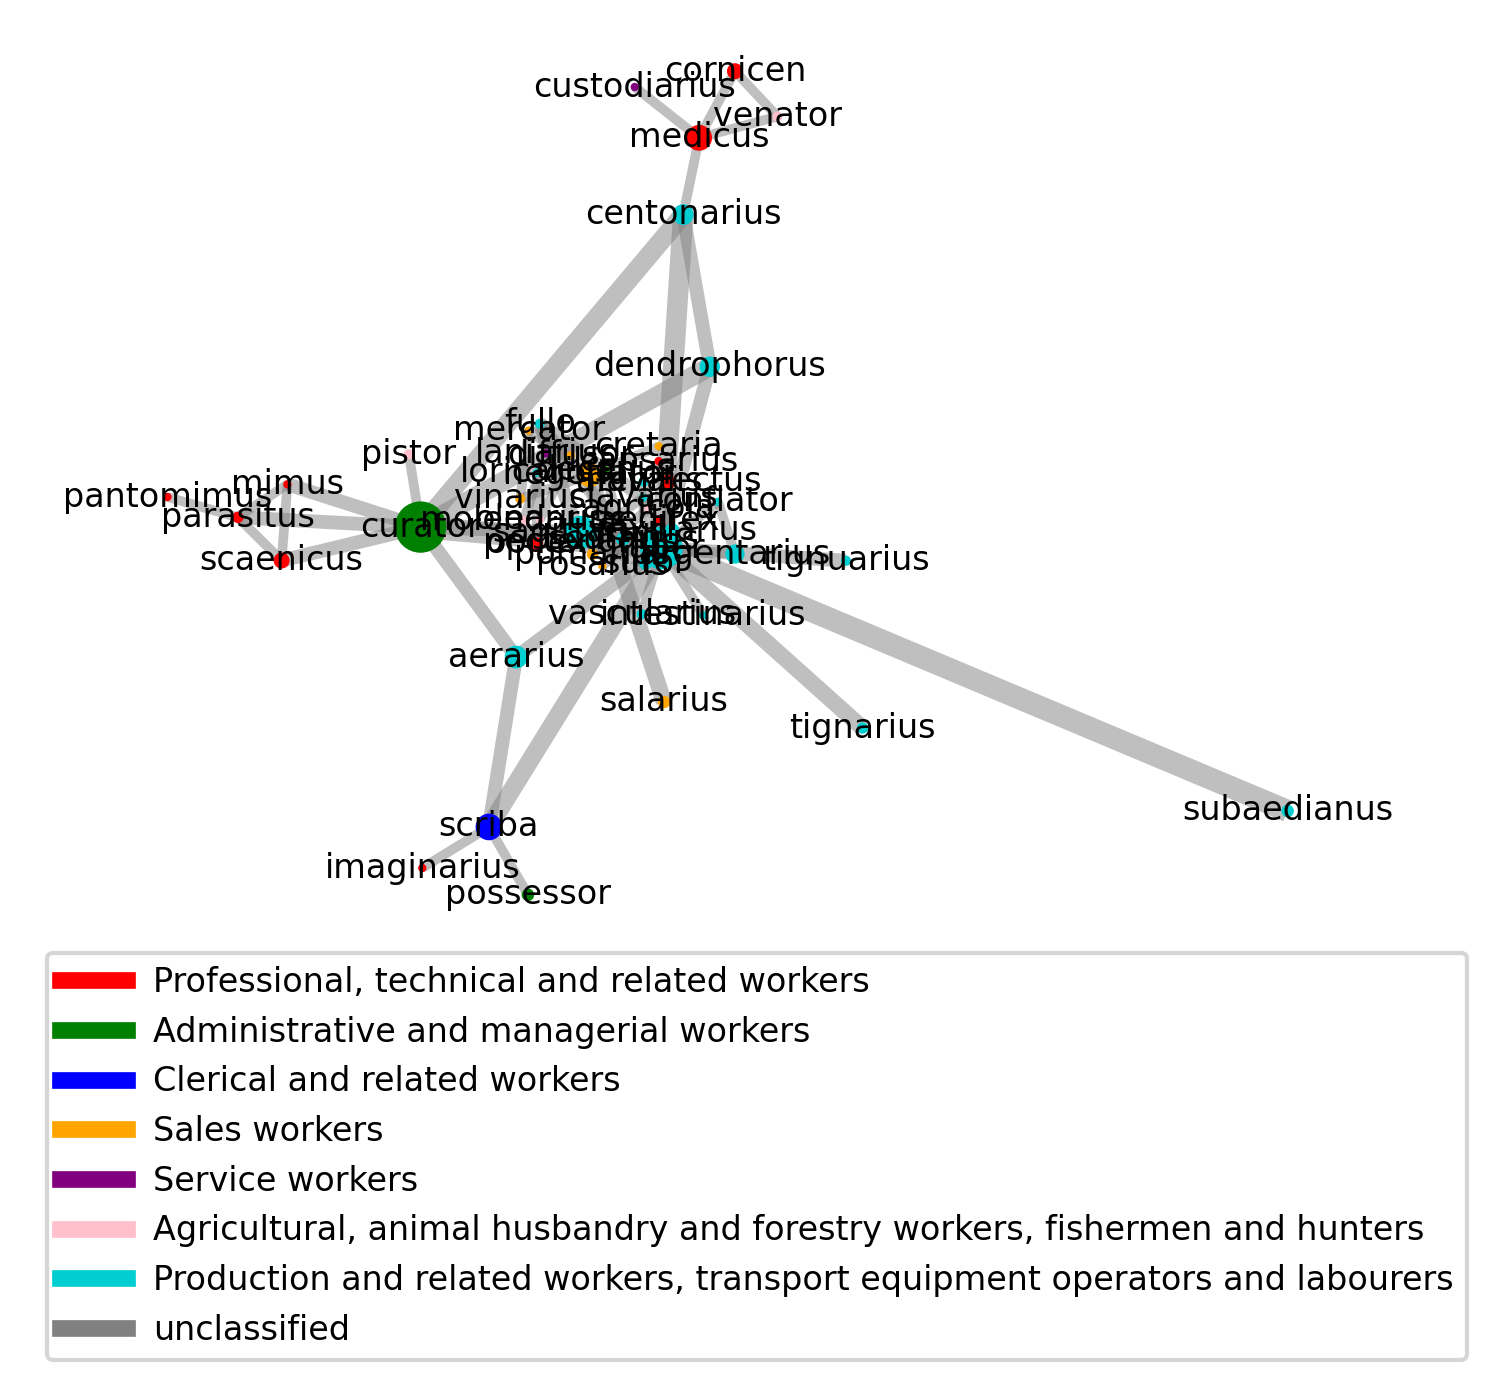

In [460]:
plot_network(G_minor, N_nodes=50, legend_dict=hisco_colors_dict)